In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data 2
import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


from keras.layers import LSTM, Dropout, Dense, MaxPooling1D, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Reshape
from keras.regularizers import l2

In [2]:
#importing all 12,000 data entries to one file for treatment
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126108 entries, 0 to 126107
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  126108 non-null  object
 1   age       126108 non-null  int64 
 2   gender    126108 non-null  object
 3   accent    126108 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [3]:
df['filename'] = df['filename'].str.replace('D:/AMINA/PFE24/datasets/commonvoice/', '')
df.head(2)

,filename,age,gender,accent
0,cv-valid-train/cv-valid-train/sample-000005.mp3,2,female,us
1,cv-valid-train/cv-valid-train/sample-000008.mp3,7,male,us


In [57]:
# Feature extraction
ds_path = "D:/AMINA/PFE24/datasets/commonvoice/"

def feature_extraction(filename, sampling_rate=16000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
 
    gender = df[df['filename'] == filename].gender.values[0]
    accent = df[df['filename'] == filename].accent.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(accent)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate) #16kHz
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
features = feature_extraction(df.iloc[0]['filename'])
print("features: ", features)

features:  ['female', 'us', 1681.5324139796423, 1680.8059344270619, 3543.6304644808743, -552.03424, 72.4191, 26.703245, 36.881405, -12.264315, -4.6388655, -18.739496, 0.186498, -15.599341, -15.913729, -15.611613, -6.366278, -6.7531643, -6.604417, -9.284645, 0.51824677, -8.63934, -10.15817, -2.9375417, -6.451939]


In [58]:
def create_df_features(orig):
    new_rows = []
    tot_rows = len(orig) - 1
    stop_counter = 130000
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter:
            break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)
    
    # Define column names for the features DataFrame
    column_names = ["gender", "accent", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                    "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                    "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age"]
    
    return pd.DataFrame(new_rows, columns=column_names)

# Uncomment the line below if running for the first time
#df_features = create_df_features(df)

0/126107

126107/126107

In [23]:
#df_features.to_csv('df_features.csv', index=False) # to save to disk
df_features = pd.read_csv('df_features.csv')
df_features.head(2)

,gender,accent,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age
0,female,us,1681.532414,1680.805934,3543.630464,-552.03424,72.41910,26.703245,36.881405,-12.264315,...,-6.366278,-6.753164,-6.604417,-9.284645,0.518247,-8.639340,-10.15817,-2.937542,-6.451939,2
1,male,us,2020.193755,1424.773656,3422.301136,-390.63916,86.60778,-31.042065,17.366293,1.816059,...,-2.807799,-12.215798,-7.395828,-7.008618,1.758026,-2.460396,-3.82122,-5.165414,-5.350076,7


In [24]:
categorical_cols = ['gender', 'accent']
numerical_cols = [col for col in df_features.columns if col not in ['age', 'gender', 'accent']]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(df_features.drop(columns=['age']))
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_features['age'])

X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
model = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(units=256, return_sequences=True),
    Dropout(0.1),
    LSTM(units=128),
    Dropout(0.1),
    Flatten(),
    Dense(units=32, activation='relu'),
    BatchNormalization(),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    epochs=10, batch_size=32, validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val))
X_test = scaler.transform(X_test)
y_pred_probabilities = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = np.argmax(y_pred_probabilities, axis=1)

y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))
recall = recall_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))
f1 = f1_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(y_pred_decoded))

Epoch 1/10
3153/3153 [==============================] - 639s 201ms/step - loss: 1.6598 - accuracy: 0.3310 - val_loss: 1.4593 - val_accuracy: 0.4371
Epoch 2/10
3153/3153 [==============================] - 653s 207ms/step - loss: 1.2449 - accuracy: 0.5375 - val_loss: 0.9484 - val_accuracy: 0.6671
Epoch 3/10
3153/3153 [==============================] - 646s 205ms/step - loss: 0.8315 - accuracy: 0.7097 - val_loss: 0.7020 - val_accuracy: 0.7546
Epoch 4/10
3153/3153 [==============================] - 635s 201ms/step - loss: 0.5992 - accuracy: 0.7945 - val_loss: 0.5270 - val_accuracy: 0.8214
Epoch 5/10
3153/3153 [==============================] - 635s 201ms/step - loss: 0.4570 - accuracy: 0.8431 - val_loss: 0.4649 - val_accuracy: 0.8424
Epoch 6/10
3153/3153 [==============================] - 655s 208ms/step - loss: 0.3694 - accuracy: 0.8736 - val_loss: 0.4347 - val_accuracy: 0.8536
Epoch 7/10
3153/3153 [==============================] - 643s 204ms/step - loss: 0.3008 - accuracy: 0.8977 - val_

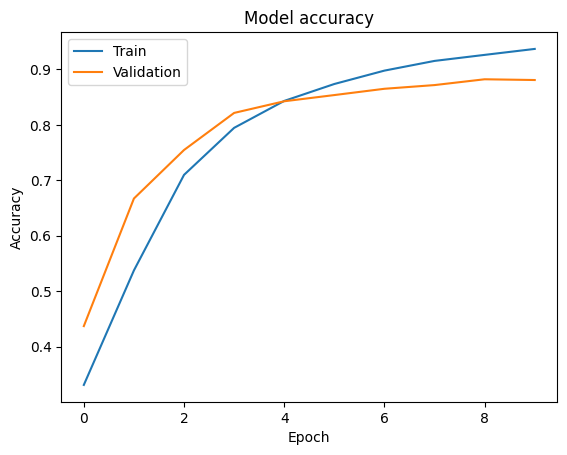

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
print(X_train.shape[1])

42


In [27]:
#Performance
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8827214336690191
Precision: 0.8829625342832359
Recall: 0.8827214336690191
F1 Score: 0.8827948669846181


In [28]:
# Count the occurrences of each unique age label in train, val, and test sets
train_age_counts = np.bincount(y_train)
val_age_counts = np.bincount(y_val)
test_age_counts = np.bincount(y_test)

# Print the counts for each age label in each subset
print("Train set age counts:")
for age_label, count in enumerate(train_age_counts):
    print(f"Age label {age_label}: {count} instances")

print("\nValidation set age counts:")
for age_label, count in enumerate(val_age_counts):
    print(f"Age label {age_label}: {count} instances")

print("\nTest set age counts:")
for age_label, count in enumerate(test_age_counts):
    print(f"Age label {age_label}: {count} instances")

Train set age counts:
Age label 0: 6431 instances
Age label 1: 29305 instances
Age label 2: 26156 instances
Age label 3: 15265 instances
Age label 4: 14316 instances
Age label 5: 6789 instances
Age label 6: 2264 instances
Age label 7: 360 instances

Validation set age counts:
Age label 0: 804 instances
Age label 1: 3663 instances
Age label 2: 3269 instances
Age label 3: 1909 instances
Age label 4: 1789 instances
Age label 5: 849 instances
Age label 6: 283 instances
Age label 7: 45 instances

Test set age counts:
Age label 0: 804 instances
Age label 1: 3663 instances
Age label 2: 3270 instances
Age label 3: 1908 instances
Age label 4: 1790 instances
Age label 5: 848 instances
Age label 6: 283 instances
Age label 7: 45 instances


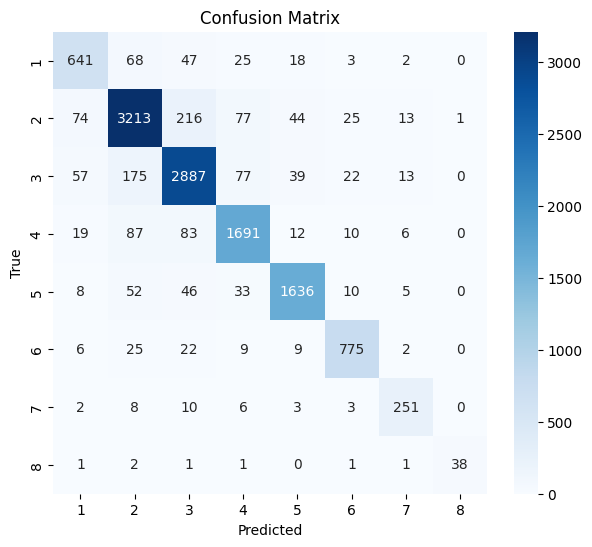

In [32]:
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Create a DataFrame with the test results
results_df = pd.DataFrame({'Actual_Age': y_test_decoded, 'Predicted_Age': y_pred_decoded})

# Merge the results DataFrame with the original features DataFrame to get gender and accent information
results_df = pd.concat([results_df, df_features.reset_index(drop=True)], axis=1)

# Drop rows with NaN values
results_df = results_df.dropna()

# Group by gender and accent, then calculate accuracy for each group
accuracy_per_group = results_df.groupby(['gender', 'accent']).apply(lambda x: accuracy_score(x['Actual_Age'], x['Predicted_Age']))

# Print accuracy per gender and accent
print("Accuracy per gender and accent:")
print(accuracy_per_group)

# Calculate overall accuracy
overall_accuracy = accuracy_score(results_df['Actual_Age'], results_df['Predicted_Age'])

# Print overall accuracy
print("Overall Accuracy:", overall_accuracy)

Accuracy per gender and accent:
gender  accent        
female  african           0.868421
        australia         0.875000
        bermuda           0.800000
        canada            0.905660
        england           0.892655
        indian            0.883495
        ireland           0.900000
        malaysia          1.000000
        newzealand        0.888889
        philippines       0.909091
        scotland          0.960000
        singapore         0.769231
        us                0.880984
male    african           0.903448
        australia         0.894309
        bermuda           0.950000
        canada            0.896018
        england           0.877852
        hongkong          0.750000
        indian            0.900166
        ireland           0.907143
        malaysia          0.862069
        newzealand        0.854839
        philippines       0.968750
        scotland          0.883817
        singapore         0.909091
        southatlandtic    0.888889


In [33]:
model.save('my_model.h5')